# 1. Introduction

Nama : Sigit Pramana

Dataset : https://www.kaggle.com/datasets/ilhamfp31/kue-indonesia

Objective : Membuat klasifikasi dan prediksi tentang sebuah gambar kue, termasuk jenis kue apakah gambar tersebut, berdasarkan dataset yang tersedia

# 2. Import Libraries

In [3]:
# import libraries

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D,Dense, Flatten, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

import warnings
warnings.filterwarnings('ignore')


# 3. Data Loading

In [3]:
# load kaggle.json

!mkdir ~/.kaggle

# !cp 'kaggle.json' ~/.kaggle
!cp '/content/kaggle.json' ~/.kaggle

!ls ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
kaggle.json


In [4]:
# download dataset from kaggle

!kaggle datasets download -d ilhamfp31/kue-indonesia

 98% 297M/303M [00:05<00:00, 44.0MB/s]
100% 303M/303M [00:05<00:00, 57.1MB/s]


In [5]:
# unzip dataset

!unzip -q /content/kue-indonesia.zip -d images

In [6]:
# make main path

main_path= '/content/images/'
os.listdir(main_path)

['train', 'validation', 'test']

In [7]:
# make train, val, dan test path

train_path = os.path.join(main_path, 'train') 
test_path = os.path.join(main_path, 'test')
val_path = os.path.join(main_path, 'validation')

# 4. Exploratory Data Analysis

In [8]:
# look train path

items = os.listdir(train_path)
items

['kue_kastengel',
 'kue_serabi',
 'kue_putri_salju',
 'kue_lumpur',
 'kue_dadar_gulung',
 'kue_klepon',
 'kue_lapis',
 'kue_risoles']

- Dalam trainset terdapat 8 jenis kue, salah satunya adalah kue serabi

In [92]:
# look averange shape on train path

for directory in [train_path]:
    total_width = 0
    total_height = 0
    num_images = 0
    
    for subdir, _, files in os.walk(directory):
        for file in files:
            img_path = os.path.join(subdir, file)
            img = Image.open(img_path)
            width, height = img.size
            total_width += width
            total_height += height
            num_images += 1
    avg_width = total_width / num_images
    avg_height = total_height / num_images
    print(f"{directory}: average image size is ({avg_width:.2f}, {avg_height:.2f}) pixels")

/content/images/train: average image size is (819.94, 641.98) pixels


- Rata-rata shape pada gambar adalah 820 x 642 pixels

In [96]:
# look every label on train path

label_counts = {}

for directory in [train_path]:
    for subdir in os.listdir(directory):
        label_counts.setdefault(subdir, 0)
        subdir_path = os.path.join(directory, subdir)
        label_counts[subdir] += len(os.listdir(subdir_path))

for label, count in label_counts.items():
    print(f"{label}: {count}")

kue_lumpur: 198
kue_risoles: 196
kue_klepon: 200
kue_lapis: 201
kue_putri_salju: 174
kue_dadar_gulung: 192
kue_kastengel: 181
kue_serabi: 181


- Dilihat dari gambar setiap labelnya cukup seimbang, jadi dataset balance, tapi datanya cukup sedikit

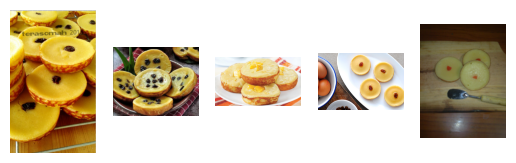

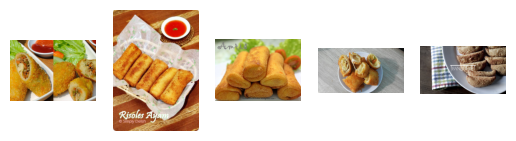

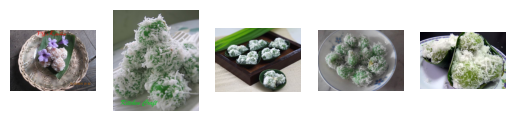

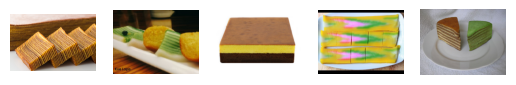

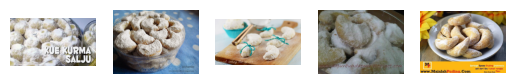

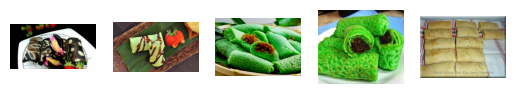

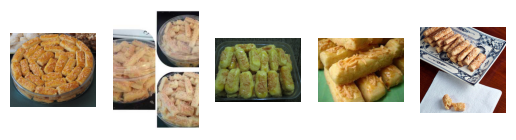

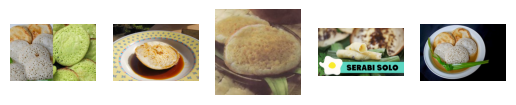

In [115]:
# check random picture of train path

for directory in [train_path]:
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = random.sample(os.listdir(subdir_path), 5)
        for i, file in enumerate(image_files):
            img_path = os.path.join(subdir_path, file)
            img = plt.imread(img_path)
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

- Dalam data gambar pada train path tidak ada gambar yang nyleneh atau diluar topik kue, hanya ada beberapa tulisan saja pada beberapa gambar

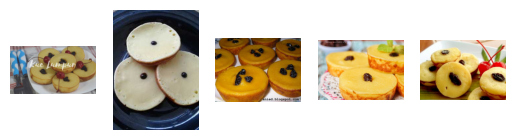

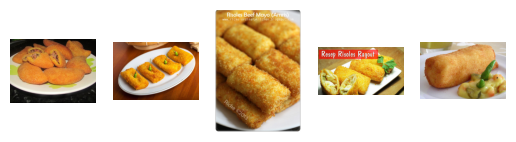

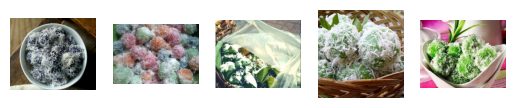

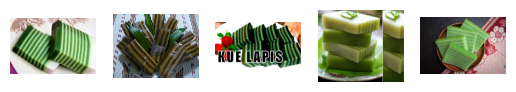

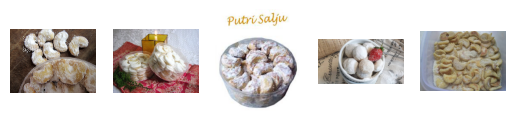

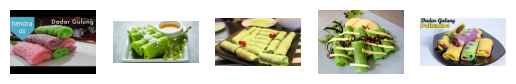

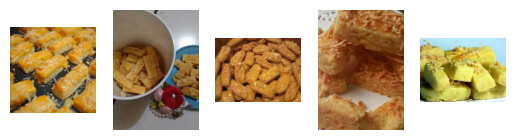

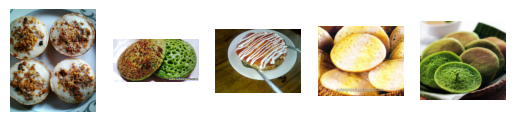

In [108]:
# check random picture of val path

for directory in [val_path]:
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = random.sample(os.listdir(subdir_path), 5)
        for i, file in enumerate(image_files):
            img_path = os.path.join(subdir_path, file)
            try:
                img = plt.imread(img_path)
            except SyntaxError:
                print(f"Skipping {img_path} as it is not a valid PNG file.")
                continue
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

- Gambar dalam val path juga aman, tidak ada yang menyimpang, semuanya gambar kue

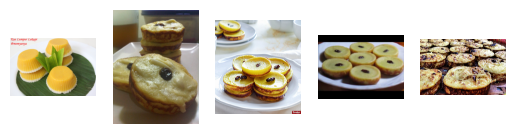

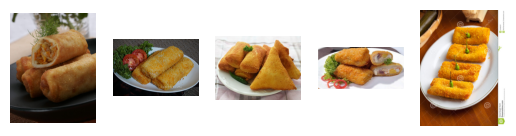

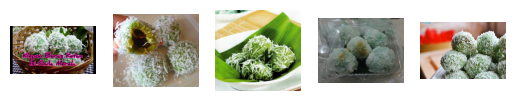

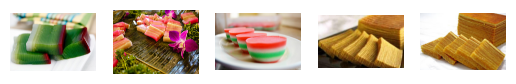

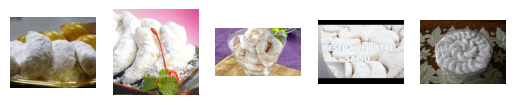

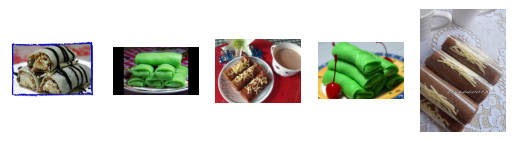

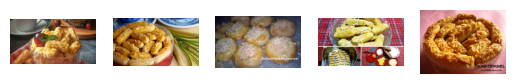

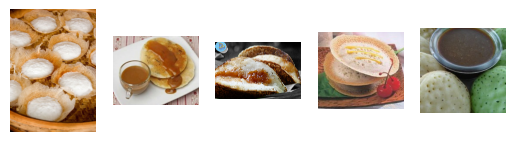

In [109]:
# check random picture of test path

for directory in [test_path]:
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = random.sample(os.listdir(subdir_path), 5)
        for i, file in enumerate(image_files):
            img_path = os.path.join(subdir_path, file)
            try:
                img = plt.imread(img_path)
            except SyntaxError:
                print(f"Skipping {img_path} as it is not a valid PNG file.")
                continue
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

- Gambar pada test path juga aman, cukup jelas semuanya dan tidak ada yang menyimpang, gambar kue semuanya

Karena pada dataset gambar sudah sesuai dan bagus hapir tidak ada noise yang terlihat, maka selanjutnya adalah preprosesing data agar bisa di proses pada model

# 5. Feature Engginering

Dalam proses ini saya mencoba untuk membuat label untuk data gambar pada seluruh dataset, train val dan test

In [9]:
# make label for image in train, val, and test 

img_height = 150
img_width = 150
batch_size = 15

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

Found 1523 files belonging to 8 classes.
Found 160 files belonging to 8 classes.
Found 162 files belonging to 8 classes.


In [10]:
# check label on test path

class_names = train_ds.class_names

label_to_index = dict((name, index) for index, name in enumerate(class_names))
print("Label Index:")
print(label_to_index)

Label Index:
{'kue_dadar_gulung': 0, 'kue_kastengel': 1, 'kue_klepon': 2, 'kue_lapis': 3, 'kue_lumpur': 4, 'kue_putri_salju': 5, 'kue_risoles': 6, 'kue_serabi': 7}


In [5]:
# make onehot encoding

num_classes = 8

train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))


In [6]:
# add an AUTOTUNE

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

- Menambahkan autotune untuk mempercepat proses training

# 6. CNN Model without Augmentation

Disini saya mencoba membuat model sendiri dengan sequential API dengan menggunnakan layer konvolusi 2 dimensi dimana layer pertama menggunakan 16 filter, layer kedua menggunakan 32 filter dan layer ketiga menggunakan 64 filter, untuk maxpoolingnya menggunakan base model yaitu 2x2, serta aktivation tiap layer menggunakan relu, setelah di flatten dense untuk ouputnya saya mencoba dengan menggunakan 128 neuron saja untuk membuat prediksi

## Model Definition

In [5]:
# model definition without Augmentation

model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        1

- Karena output yang dihasilkan adalah multiclass maka saya menggunakan activation softmax dan untuk mengoptimalkan loss functionnya saya menggunakan categorical_crossentropy, selain itu saya menambahkan optimizer adam pada model yang saya buat, serta matric evaluasi yang saya pakai adalah accuracy

## Model Training

In [21]:
# train model

epochs = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
102/102 [==============================] - 56s 439ms/step - loss: 1.7822 - accuracy: 0.2889 - val_loss: 1.6089 - val_accuracy: 0.3362
Epoch 2/30
102/102 [==============================] - 46s 449ms/step - loss: 1.4340 - accuracy: 0.4314 - val_loss: 1.3829 - val_accuracy: 0.4879
Epoch 3/30
102/102 [==============================] - 44s 434ms/step - loss: 1.2276 - accuracy: 0.5378 - val_loss: 0.9726 - val_accuracy: 0.6651
Epoch 4/30
102/102 [==============================] - 45s 447ms/step - loss: 0.9357 - accuracy: 0.6645 - val_loss: 0.7499 - val_accuracy: 0.7249
Epoch 5/30
102/102 [==============================] - 44s 428ms/step - loss: 0.6948 - accuracy: 0.7643 - val_loss: 0.3905 - val_accuracy: 0.8884
Epoch 6/30
102/102 [==============================] - 45s 440ms/step - loss: 0.3801 - accuracy: 0.8897 - val_loss: 0.2515 - val_accuracy: 0.9284
Epoch 7/30
102/102 [==============================] - 45s 438ms/step - loss: 0.2538 - accuracy: 0.9179 - val_loss: 0.1470 - val_ac

## Model Evaluation

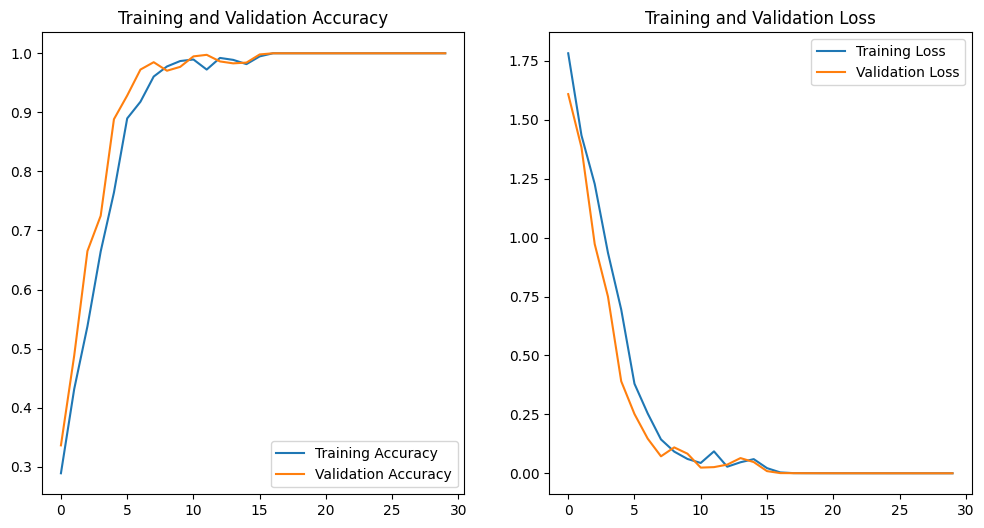

In [22]:
# check performance model on trainset and valset

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Terlihat pada chart diatas performa model terlihat sangat bagus sekali, tidak overfit, tidak explode gradient juga, dan val lossnya sudah konvergen mendekati 0, dan akurasinya sangat tinggi, dilihat pada gambar saja akurasinya pasti diatas 95% mari kita coba ke dalam data test

In [23]:
# evaluate model performance on test set

test_results_1 = model.evaluate(test_ds)

11/11 [==============================] - 2s 191ms/step - loss: 2.0781 - accuracy: 0.7160


- Dalam data test ternyata model tidak sebagus itu performanya, malah sangat overfit dimana akurasinya hanya 71% saja

# CNN Model with Augmentation

Dalam model kali ini saya mencoba menambahkan data dengan augmentasi, dimana gambar secara acak ada yang di flip secara horizontal, di rotasi, dan di zoom, untuk lapisan layer, parameter dan architecturnya masih sama dengan model sebelumnya

## Model Definition

In [12]:
# define an augmentation

data_aug= Sequential(
    [
      layers.RandomFlip('horizontal',
                          input_shape=(img_height, img_width, 3)),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1),
    ]
)

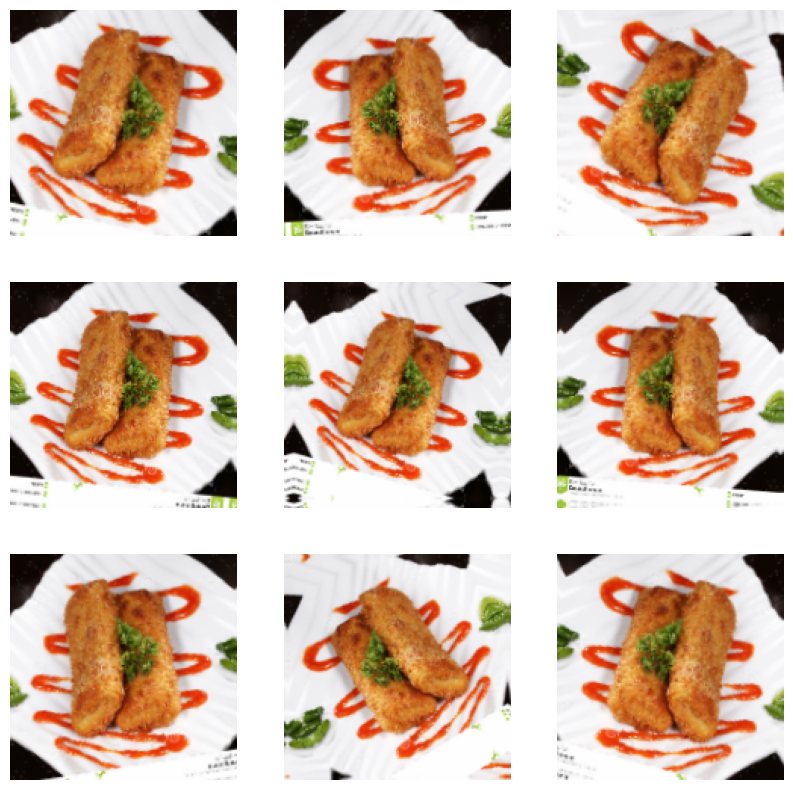

In [13]:
# show augmentation data

plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_img= data_aug(images)
    ax=plt.subplot(3, 3, i +1)
    plt.imshow(augmented_img[0].numpy().astype('uint8'))
    plt.axis('off')

In [17]:
# model definition and architecture

model_2 = Sequential([
    data_aug,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                  

## Model Training

In [18]:
# train model

epochs = 25

history_2= model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/25
102/102 [==============================] - 54s 512ms/step - loss: 1.7721 - accuracy: 0.2955 - val_loss: 1.5542 - val_accuracy: 0.3828
Epoch 2/25
102/102 [==============================] - 50s 495ms/step - loss: 1.5326 - accuracy: 0.3926 - val_loss: 1.4568 - val_accuracy: 0.4531
Epoch 3/25
102/102 [==============================] - 49s 480ms/step - loss: 1.4149 - accuracy: 0.4629 - val_loss: 1.3050 - val_accuracy: 0.5023
Epoch 4/25
102/102 [==============================] - 50s 492ms/step - loss: 1.3647 - accuracy: 0.4977 - val_loss: 1.3092 - val_accuracy: 0.5345
Epoch 5/25
102/102 [==============================] - 51s 497ms/step - loss: 1.2895 - accuracy: 0.5246 - val_loss: 1.2335 - val_accuracy: 0.5305
Epoch 6/25
102/102 [==============================] - 50s 490ms/step - loss: 1.2520 - accuracy: 0.5463 - val_loss: 1.2056 - val_accuracy: 0.5614
Epoch 7/25
102/102 [==============================] - 50s 494ms/step - loss: 1.2079 - accuracy: 0.5417 - val_loss: 1.0916 - val_ac

## Model Evaluation

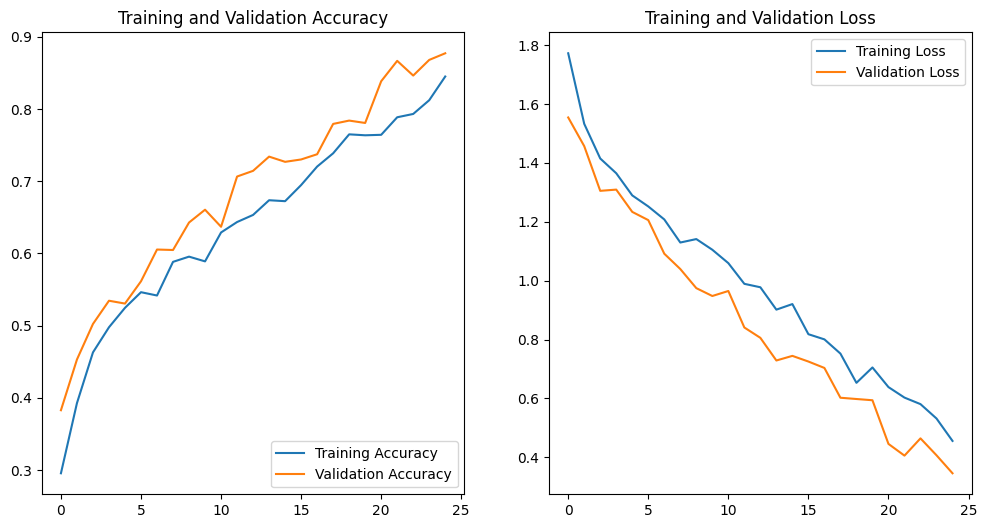

In [19]:
# check performance model om trainset and valset

acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Dari chart diatas terlihhat model tidak terlalu overfit dan konvergen ke 0, cukup baik, hanya karena prosesnya lama saya hanya mencoba model sampai epochs 25 saja

In [48]:
# check performance model on test set

test_results_2 = model_2.evaluate(test_ds)

11/11 [==============================] - 2s 183ms/step - loss: 0.8730 - accuracy: 0.7407


- Dalam data test akurasi model cuma 74% padahal di train dan val bisa sampai 80% lebih, ini menunjukan bawha model overfit dan akurasi pada data test rendah. Namun jika di bandingkan dengan model sebelumnya yang tanpa augmentasi, disini dengan augmentasi performa model bisa meningkan, model tidak terlalu overfit seperti pada model sebelumnya

# 8. Transfer Learning Model with EfficientNetB3

Karena model yang saya buat akurasinya cukup rendah maka disini saya coba menggunakan transfer learning untuk membuat model baru, dan disini saya coba menggunakan EfficientNetB3. Saya coba menngunakan model ini karena akurasinya yang cukup tinggi di bandingkan model lain pada dataset yang saya kerjakan, serta memiliki parameter yang lebih sedikit. Sebelumnya saya mencoba dengan EfficientNetB7 dan trainingnya lebih lama, serta hasilnya lebih baik yang B3

## Model Definition

In [10]:
# make label with ImageDataGenerator

TRAINING_DIR = train_path
train_datagen = ImageDataGenerator( rescale = 1.0/255. ,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

VALIDATION_DIR = val_path
validation_datagen = ImageDataGenerator( rescale = 1.0/255. ,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))
TEST_DIR = test_path
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=10)

Found 1516 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [87]:
# check label for classes

print(train_generator.class_indices)

{'kue_dadar_gulung': 0, 'kue_kastengel': 1, 'kue_klepon': 2, 'kue_lapis': 3, 'kue_lumpur': 4, 'kue_putri_salju': 5, 'kue_risoles': 6, 'kue_serabi': 7}


In [ ]:
!pip install efficientnet

In [ ]:
# calling EfficientNetB3

from efficientnet.tfkeras import EfficientNetB3

pre_trained_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(150, 150, 3),
    pooling='avg',
)

In [14]:
# fully add layer from EfficientNetB3

for layer in pre_trained_model.layers:
    layer.trainable = False


last_layer = pre_trained_model.get_layer('avg_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (8, activation='softmax')(x)           

model_3 = Model( pre_trained_model.input, x) 

model_3.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

last layer output shape:  (None, 1536)


In [15]:
# define callback

def callbacks(model_name):
    cb = []

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                       factor=0.5, patience=1, 
                                       verbose=1, mode='min', 
                                       min_lr=0,
                                       restore_best_weights=True)
    cb.append(reduceLROnPlat)
    
    log = CSVLogger('log_{}.csv'.format(model_name))
    cb.append(log)
    
    es = EarlyStopping(monitor='val_loss', patience=4, verbose=0,
                       mode='min', restore_best_weights=True)
    
    cb.append(es)
    
    return cb

- Membuat training lebih cepat dengan EarlyStopping dan ReduceLROnPlateau agar learning ratenya dapat menyesuaikan dengan otomatis

## Model Training

In [16]:
# train model efficientnetB3

epochs = 30
history_3 = model_3.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = epochs,
            verbose = 1,
            callbacks = callbacks('model_efficientnetb3'))

Epoch 1/30
95/95 [==============================] - 187s 2s/step - loss: 0.9064 - accuracy: 0.6913 - val_loss: 0.6444 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 2/30
95/95 [==============================] - 162s 2s/step - loss: 0.5253 - accuracy: 0.8199 - val_loss: 0.5040 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 3/30
95/95 [==============================] - 147s 2s/step - loss: 0.4433 - accuracy: 0.8476 - val_loss: 0.4349 - val_accuracy: 0.8562 - lr: 0.0010
Epoch 4/30
95/95 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8707
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
95/95 [==============================] - 168s 2s/step - loss: 0.3866 - accuracy: 0.8707 - val_loss: 0.4774 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 5/30
95/95 [==============================] - ETA: 0s - loss: 0.3314 - accuracy: 0.8773
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
95/95 [==============================] - 164s 2s/step -

## Model Evaluation

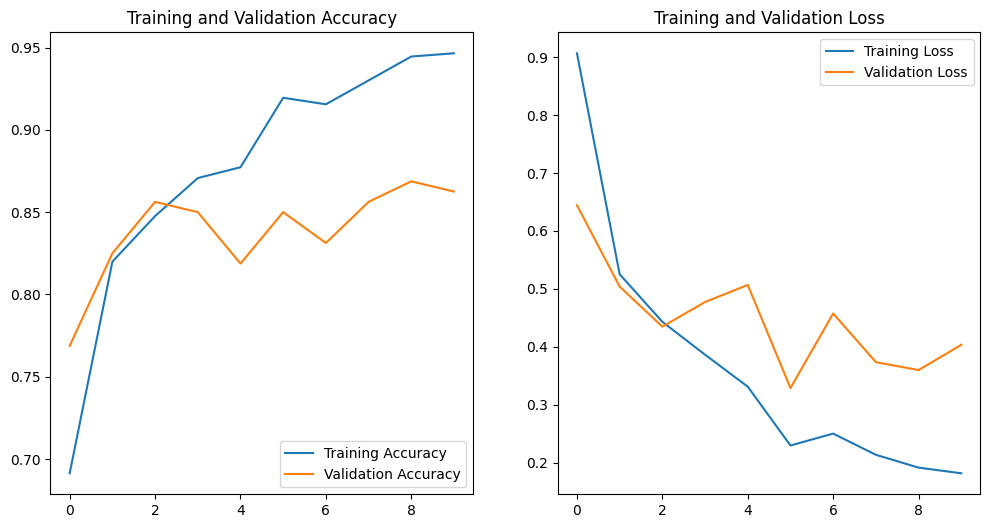

In [17]:
# check performance model on trainset and valset

acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Model terlihat overfit jika dilihat dari chart diatas jika di bandingkan dengan val testnya

In [19]:
# evaluate model with test set

test_results_3 = model_3.evaluate(test_generator)

16/16 [==============================] - 12s 679ms/step - loss: 0.2608 - accuracy: 0.9187


- Namun pada data test performa model cukup baik, akurasinya sampai 91% dimana pada val test tidak sampai segitu

# 9. Model Saving

Karenah hasil transfer learning menghasilkan performa paling bagus di test set dengan akurasi 91% maka saya akan menggunakan model ini pada kasus saya

In [ ]:
# freez model

model_3.trainable = False
model_3.summary()


In [21]:
# save cnn model

model_3.save('kue_model.h5')

# 10. Model Inference

Saving 3.jpg to 3 (2).jpg


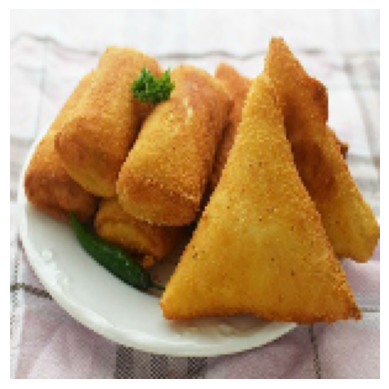

tf.Tensor([[0. 0. 0. 0. 0. 0. 1. 0.]], shape=(1, 8), dtype=float32)
Predicted class: kue_risoles


In [81]:
# model inference with upload image

import numpy as np
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
 
  path = fn
  img =  tf.keras.utils.load_img(path, target_size=(150,150))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_3(images)
  print(classes)
  class_names = ['kue_dadar_gulung', 'kue_kastengel', 'kue_klepon', 'kue_lapis', 'kue_lumpur', 'kue_putri_salju', 'kue_risoles', 'kue_serabi']
  class_idx = np.argmax(classes)
  class_name = class_names[class_idx]
  print('Predicted class:', class_name)

# 11. Conclusion

Dalam kasus kali ini untuk mengklasisifaksi sebuah gambar terutama gambar kue, pada datasetnya hanya terbatas pada 8 class, yaitu : 1.Kue Dadar Gulung, 2. Kue Kastengel, 3.Kue Klepon, 4.Kue Lapis, 5.Kue Lumpur, 6.Kue Putri Salju, 7.Kue Risoles, 8. Kue Serabi. Karakteristik tiap kuenya juga terdaapat perbedaan yang cukup signifikan, jadi cukup mudah di kenali. Selain itu pada dataset minim noise, tidak ada gambar yang out of topic, semuanya gambar kue. Setelah mencoba membuat model sendiri dengan Sequential API  tanpa augmentasi, saya mendapati model yang saya buat sangat overfit, dimana akurasi train bisa 100% namun pada test hanya 71%, selanjutnya saya mencoba menambahkan augmentasi pada model dan hasilnya sama sama overfit, tapi menurun dimana sebelumnya pada data tarin akurasinya sekitar 84% dan dalam test 74%. Karena kedua model yang saya buat overfit, saya mencoba menggunakan tranfer learning, dimana saya menggunakan EfficientNetB3, dan mendapati akurasi yang cukup tinggi yaitu 91% pada data test, maka dalam kasus ini untuk mengklasifikasi gambar saya menggunakan model transfer learning EfficientNetB3. Setelah di deploy dan mengunggah gambar baru yang bukan dari dataset model mampu memprediksi dengan baik dan akurat. Namun model hanya terbatas pada 8 jenis kue saja, ini terjadi karena keterbatasan datasetnya.